In [1]:
import pandas as pd
import numpy as np 
import sqlite3
import matplotlib.pyplot as plt
import re

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20,7)

In [22]:
conn = sqlite3.connect('../parsing/HH_vacancy.db')
df = pd.read_sql('select * from WOWEN',con=conn)
conn.close()


df['Tags'] = df['Tags'].str.findall(r'([A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$)))')

df['Salary'] = df['Salary'].str.replace('\xa0','').str.extract('(\d+)').astype('float')
df['Salary'] = df['Salary'].apply(lambda x: x*80 if x < 10000 else x)

df ['Stack'] = df['Description'].str.findall('([A-Z][A-z]{2,})').apply(lambda x: list(set(x)))


In [4]:
df['Stack'].explode().value_counts().iloc[:20]

Linux         141
DevOps        139
Docker        126
Kubernetes    123
Ansible       114
Python         97
Prometheus     91
Grafana        81
PostgreSQL     77
Gitlab         63
Jenkins        62
Kafka          61
GitLab         60
ELK            58
Bash           52
Zabbix         51
Terraform      45
Git            42
Nginx          41
AWS            39
Name: Stack, dtype: int64

array([[<AxesSubplot:title={'center':'1–3 года'}, xlabel='Stack'>,
        <AxesSubplot:title={'center':'3–6 лет'}, xlabel='Stack'>],
       [<AxesSubplot:title={'center':'более 6 лет'}, xlabel='Stack'>,
        <AxesSubplot:title={'center':'не требуется'}, xlabel='Stack'>]],
      dtype=object)

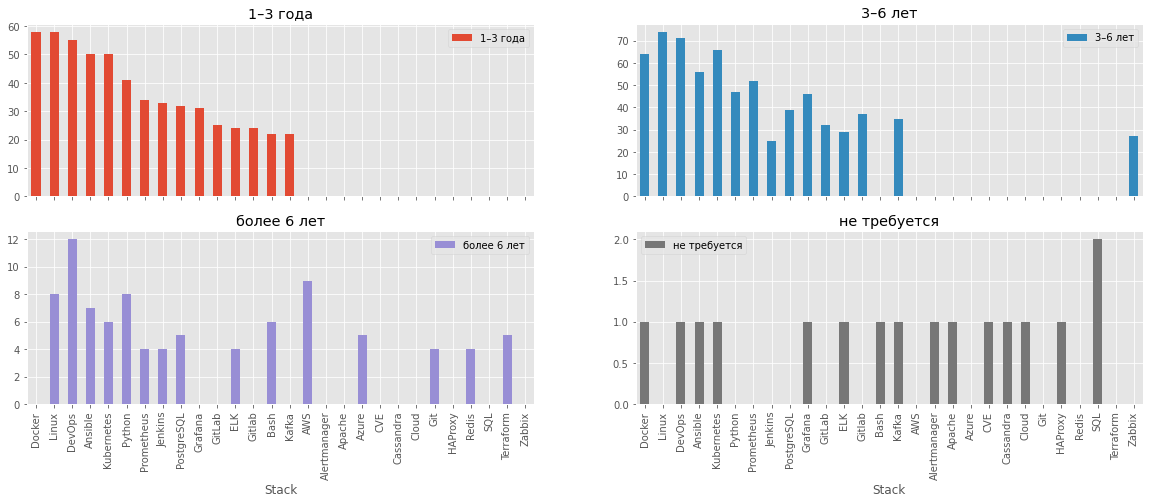

In [5]:
df[['Exp','Stack']].explode('Stack').groupby('Exp')['Stack'].value_counts()\
    .groupby(level=0).nlargest(15).reset_index(0,drop=True).unstack(0).sort_values(by='1–3 года',ascending=False).plot.bar(subplots=True,layout=(2,2))

<AxesSubplot:title={'center':'Salary'}, xlabel='Exp'>

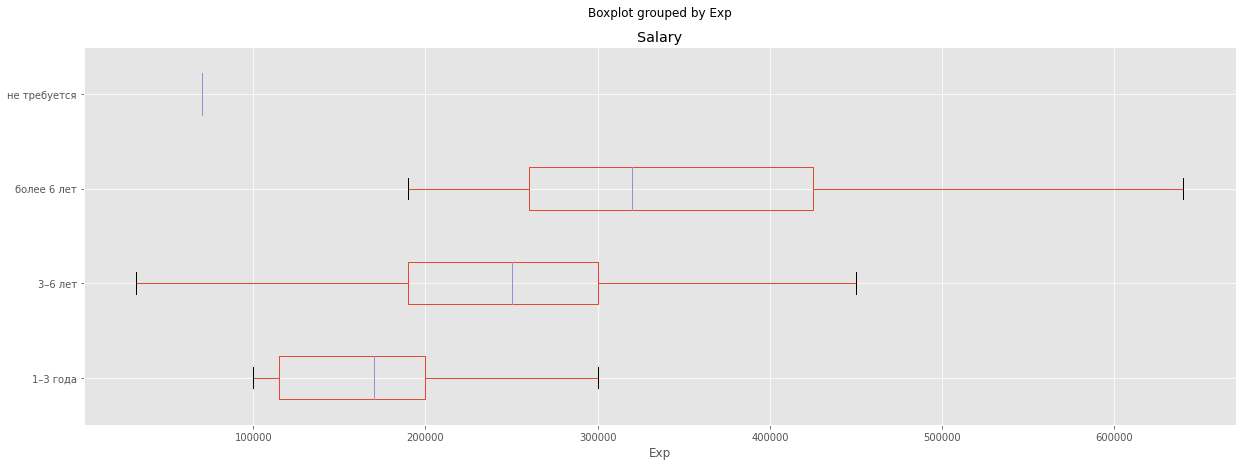

In [6]:
df.boxplot('Salary',by='Exp',vert=False)

In [7]:
df['is_russia']=df['Description'].apply(lambda x: len(re.findall('[А-я]+',x)) / (len(re.findall('[A-z]+',x)))).clip(0,1)

In [8]:
stack_salary_impact = df.query('is_russia==1')[['Stack','Salary']].explode('Stack').groupby('Stack')['Salary'].agg(['mean','count']).where(lambda x: x['count']>5).dropna()['mean'].div(df.query('is_russia!=0')['Salary'].median()).sub(1).sort_values(ascending=False)

<AxesSubplot:title={'center':'Impact of stack with median wage 200k'}, ylabel='Stack'>

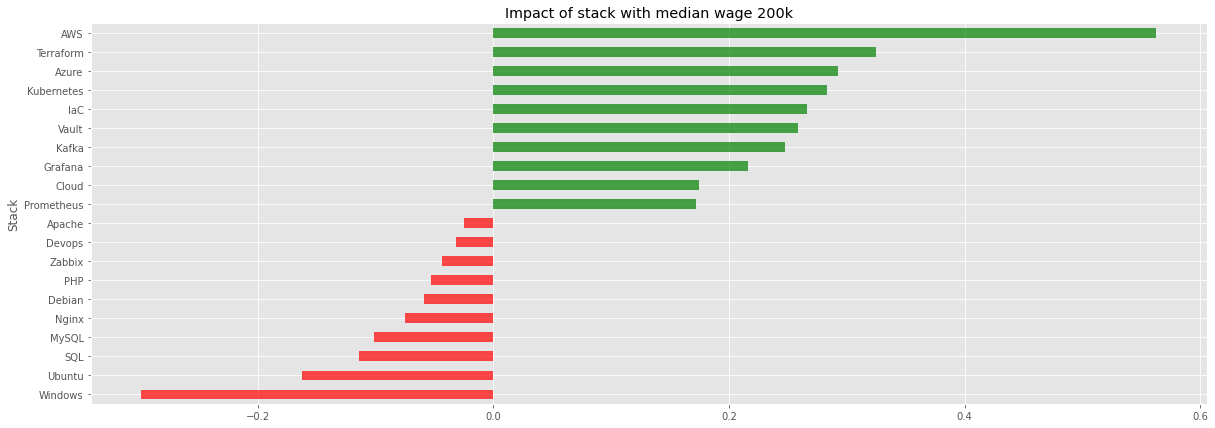

In [11]:
stack_salary_impact.head(10).append(stack_salary_impact.tail(10)).iloc[::-1].plot.barh(color=['r']*10+['g']*10,title=f'Impact of stack with median wage {df.query("is_russia!=0").Salary.median()/1000:.0f}k',alpha=0.7)

In [ ]:
df[df.Description.str.contains('[J|j]un')]

In [93]:
df[df.Description.str.contains('rtr') | df.Name.str.contains('rtr')].shape[0]

(0, 11)

In [20]:
top_30_stack = df['Stack'].explode().value_counts().iloc[:30].index

In [72]:
data = df[['Salary','Description','Exp']].dropna()

In [22]:
for i in top_30_stack:
    data[f'has_{i}'] = data['Description'].str.contains(i)

In [23]:
data['Exp'] = data['Exp'].str.findall('\d').apply(lambda x: min(x) if x!=[] else 0).astype(int)

<AxesSubplot:>

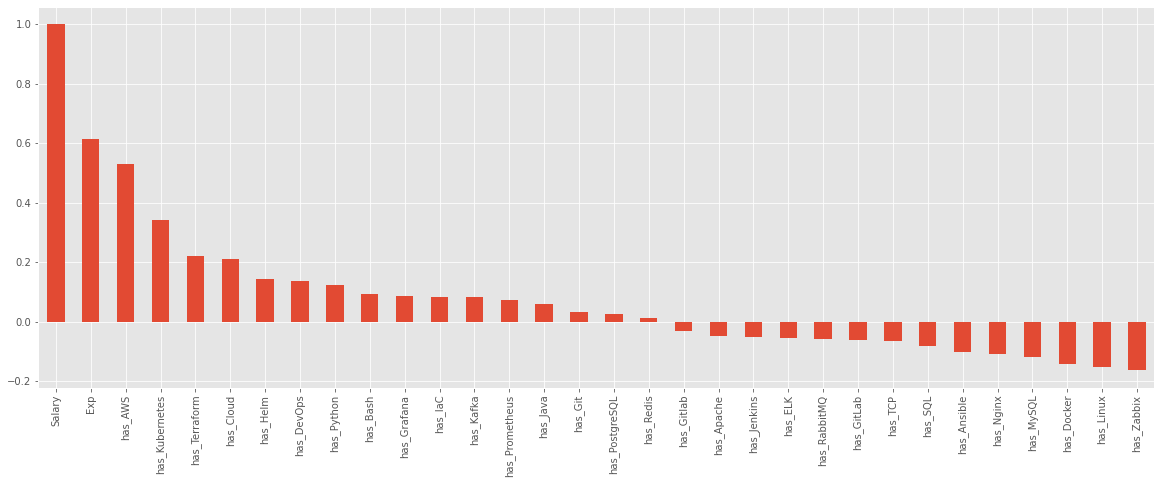

In [24]:
data.corr()['Salary'].sort_values(ascending=False).plot.bar()